# Step 0: imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import math, random
from copy import deepcopy

import encode, source, output, additions

from singer import Singer
from note import Note

%matplotlib inline

In [2]:
song = pd.read_csv('music_notes/loch_lomond.csv')
song.columns = [c.strip() for c in song.columns.values]
songnotes = song.loc[:50,['pitch (as sharps)', 'octave']]
llnotes = []
for i in range(songnotes.shape[0]):
    note = songnotes.iloc[i]['pitch (as sharps)']
    octave = int(songnotes.iloc[i]['octave'])
    llnotes.append(Note(note).at_octave(octave))
ll_freq = [n.frequency() for n in llnotes]
# fix initial note repeats
ll_freq = ll_freq[3:]
_notes = len(ll_freq)

def get_target(index):
    ''' Takes the index of the current target note
        and returns the target frequency of that note
    '''
    return ll_freq[index]

# Step 1: define our singers
We bundle all of the control and tracking of each voice into an object for easier simulation. We then set up a couple different parameters of singer to build our chorus.

In [3]:
def create_good_singer(duration, adj_per_sec, max_vol):
    return Singer(duration = duration, 
                adj_per_sec = adj_per_sec,
                pid_coeffs=(12,6,.05), max_vol=max_vol,
                starting_freq=random.randint(150,500), control_error_range=(0,0))
def create_flat_singer(duration, adj_per_sec, max_vol):
    return Singer(duration = duration, 
                adj_per_sec = adj_per_sec,
                pid_coeffs=(12,6,.05), max_vol=max_vol,
                starting_freq=random.randint(150,500), control_error_range=(0,0), noise_range=(-2,0))
def create_bad_singer(duration, adj_per_sec, max_vol):
    return Singer(duration = duration, 
                adj_per_sec = adj_per_sec,
                pid_coeffs=(7,6,.05), max_vol=max_vol,
                starting_freq=random.randint(150,500), control_error_range=(0,0))

def create_chorus(duration, num_singers = 50, adj_per_sec = 15, singer_func = create_flat_singer):
    return [singer_func(duration, adj_per_sec, 1/num_singers) for i in range(num_singers)]

def get_average_singer(singerlist):
    ttl_vols = sum(np.array([s.volumes for s in singerlist]))
    # hacky fix to avoid dividing by zero
    average = sum(np.array([s.volumes * s.realized for s in singerlist])) / (ttl_vols+0.000001)
    dummy_singer = deepcopy(singerlist[0])
    dummy_singer.volumes = ttl_vols
    dummy_singer.realized = average
    return dummy_singer
        
        

# Step 2: simulation
In this step we see what happens when we unleash our control system on the task of keeping a singer on-pitch with the target

In [4]:
# #################
# # Parameters
# #################
# # total number of eigth notes


# # number of control adjustments per second
# adj_per_sec = 15

# # duration of one eigth note
# note_duration = 0.5

# num_singers = 10
# proportion_good_ear = .1

# #################
# # setup
# #################
# # total number of control adjustments
# adj_per_note = adj_per_sec * note_duration # should be integer
# n = int(_notes * adj_per_note)

# # set up singers
# singers = []
# for i in range(num_singers):
#     singers.append(create_flat_singer(n,adj_per_sec, 1/num_singers))

# ideal = np.array(ll_freq)
# target = np.zeros(n)
# flatnesses = np.zeros(n)
# flatnesses[0] = 0


# #################
# # run simulation from t=0 to t=n-1
# #################
# prev_ideal = ideal[0]
# time_since_change = 0
# chorus_flatness = flatnesses[0]
# num_good_ear = math.floor(num_singers*proportion_good_ear)
# for t in range(1,n):
#     note_index = math.floor(t/adj_per_note)
#     ideal_target = ideal[note_index]
#     if ideal_target == prev_ideal:
#         time_since_change += 1
#     else:
#         chorus_flatness = prev_ideal - matching_target
# #         print(chorus_flatness)
#         prev_ideal = ideal_target
#         time_since_change = 0
#     prev_notes = [s.get_last_note(t) for s in singers]
#     matching_target = sum(prev_notes)/len(prev_notes)
#     matching_weight = time_since_change / adj_per_note
# #     print(matching_weight)
# #     tg = (tg + matching_weight * matching_target)/(1+matching_weight)
#     for s in singers[:num_good_ear]:
#         s.adjustment((ideal_target + matching_weight * matching_target)/(1+matching_weight))
#     for s in singers[num_good_ear:]:
#         s.adjustment(((ideal_target - chorus_flatness) + matching_weight * matching_target)/(1+matching_weight))
    
    
#     # bookkeeping
#     target[t] = ideal[note_index]
#     flatnesses[t] = chorus_flatness

In [5]:
def run_flatness_simulation(duration, chorus, proportion_good_ear, note_duration = 0.5, ):
    ideal = np.array(ll_freq)
    target = np.zeros(duration)
    flatnesses = np.zeros(duration)
    flatnesses[0] = 0

    #################
    # run simulation from t=0 to t=n-1
    #################
    prev_ideal = ideal[0]
    time_since_change = 0
    chorus_flatness = flatnesses[0]
    num_good_ear = math.floor(len(chorus)*proportion_good_ear)
    for t in range(1,duration):
        note_index = math.floor(t/adj_per_note)
        ideal_target = ideal[note_index]
        if ideal_target == prev_ideal:
            time_since_change += 1
        else:
            chorus_flatness = prev_ideal - matching_target
            prev_ideal = ideal_target
            time_since_change = 0
        prev_notes = [s.get_last_note(t) for s in chorus]
        matching_target = sum(prev_notes)/len(prev_notes)
        matching_weight = time_since_change / adj_per_note
        for s in chorus[:num_good_ear]:
            s.adjustment((ideal_target + matching_weight * matching_target)/(1+matching_weight))
        for s in chorus[num_good_ear:]:
            s.adjustment(((ideal_target - chorus_flatness) + matching_weight * matching_target)/(1+matching_weight))

        # bookkeeping
        target[t] = ideal[note_index]
        flatnesses[t] = chorus_flatness
    return target, flatnesses, chorus
def examine_results(idl, flt, ch):
    #################
    # examine results
    #################   
    chorus_singer = get_average_singer(ch)
    plt.plot(idl[1:])
    for s in ch:
        plt.plot(s.realized[1:])
    # plt.plot(chorus_singer.realized[1:])
    plt.show()
    plt.plot(flt[1:])
    plt.show()
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

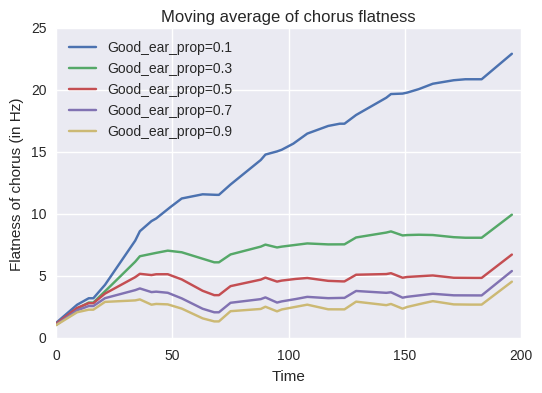

In [11]:
adj_per_sec = 15
note_duration = 0.3
adj_per_note = adj_per_sec * note_duration # should be integer
duration = int(_notes * adj_per_note)
simuls = []
for prop in np.arange(0.1, 1.0, 0.2):
#     print('good ear prop:', prop)
    ch = create_chorus(duration)
    idl, flt, ch = run_flatness_simulation(duration, ch, prop)
#     examine_results(idl, flt, ch)
    simuls.append(('Good_ear_prop={:.1f}'.format(prop), flt))
fig = plt.figure()
subplt = fig.add_subplot(111)
for title, flt in simuls:
    subplt.plot(moving_average(flt, n=20), label=title)
subplt.legend(loc='best')
subplt.set_ylabel('Flatness of chorus (in Hz)')
subplt.set_xlabel('Time')
subplt.set_title('Moving average of chorus flatness')
plt.show()

In [7]:
_, _, good_chorus = run_flatness_simulation(duration, create_chorus(duration), .9)
_, _, bad_chorus = run_flatness_simulation(duration, create_chorus(duration), .1)

# Step 6: listen
Rather than just looking at a simple graph of the simulation, we can actually listen to the simulated pitch.

In [8]:
def render_sum(singerlist):
    rendered = [s.render_singing() for s in singerlist]
    return sum(rendered)
def render_average(singerlist):
    chorus_singer = get_average_singer(singerlist)
    return chorus_singer.render_singing()

In [9]:
# output.play(render_sum(singers))

In [14]:
# output.play(render_average(good_chorus))
# output.play(render_average(bad_chorus))
# output.save_wave(render_average(good_chorus),'good_chorus.wav')
# output.save_wave(render_average(bad_chorus),'bad_chorus.wav')